In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicting-heart-disease-risk-using-clinical-var/Heart_Disease_Prediction.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os

import random
import json
from pandas.io.json import json_normalize
from scipy import stats
from datetime import datetime
from sklearn import model_selection

#gradient boosting 

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

# podemos desmarcar esta linea junto con la celda de visualización del decision tree.
import graphviz

In [3]:
def plot_num(dataframe, column, target_column):
    
    print("Atributo: ",column)
    with sns.color_palette("Set2") :
         plt.figure(figsize = (15,5))

    ax1 = plt.subplot(1,3,1)
    ax1 = dataframe[column].plot(kind= 'hist', bins = 50)

    ax2 = plt.subplot(1,3,2)
    ax2 = sns.boxplot(data = dataframe, x = target_column, y = column)

    ax3 = plt.subplot(1,3,3)
    ax3_1 = dataframe[dataframe[target_column] == 0][column].plot(kind = 'hist', bins = 25, alpha = .5)      
    ax3_2 = dataframe[dataframe[target_column] == 1][column].plot(kind = 'hist', bins = 25, alpha = .5)
    ax3 = ax3_1 
    ax3 = ax3_2
    ax3.legend(labels=["No","Yes"], loc='right')

    plt.show()

IMPORTAMOS DATOS

In [4]:
df=pd.read_csv('/kaggle/input/predicting-heart-disease-risk-using-clinical-var/Heart_Disease_Prediction.csv')

In [5]:
df.drop('index',axis=1,inplace=True)

In [6]:
df

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,3,172,199,1,0,162,0,0.5,1,0,7,Absence
266,44,1,2,120,263,0,0,173,0,0.0,1,0,7,Absence
267,56,0,2,140,294,0,2,153,0,1.3,2,0,3,Absence
268,57,1,4,140,192,0,0,148,0,0.4,2,0,6,Absence


-The attributes are
-Age, 
-Sex, 
-Chest Pain Type,
-BP (blood pressure),
-Cholesterol level,
-FBS over 120 (fasting blood sugar --> glucemia en ayunas),
-EKG Results (electrocardiogram results), 
-Max HR (maximum heart rate),
-Exercise Angina status, 
-ST Depression ( depression of ST segment on ECG)(El segmento ST muestra cuando se contrae el ventrículo, pero no hay electricidad fluyendo a través de él. La cardiopatía isquémica es la causa más frecuente de elevación o de descenso del segmento ST.) , 
-Slope of ST(slope of the ST segment on the ECG), 
-Number of Vessels Fluroscopy (number of vessels seen on fluoroscopy. La fluoroscopia muestra la sangre -circulando por las arterias. Se usa para diagnosticar y tratar algunas afecciones cardíacas. )
-Thallium Stress test results: The results of this test will tell you about the flow of blood to your heart through your coronary arteries (prueba de esfuerzo)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    object 
dtypes: float64(1), int64(12), 

In [8]:
porc_disease=df['Heart Disease'].value_counts()[1]/len(df)
porc_disease

0.4444444444444444

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,270.0,54.433333,9.109067,29.0,48.0,55.0,61.0,77.0
Sex,270.0,0.677778,0.468195,0.0,0.0,1.0,1.0,1.0
Chest pain type,270.0,3.174074,0.950090,1.0,3.0,3.0,4.0,4.0
BP,270.0,131.344444,17.861608,94.0,120.0,130.0,140.0,200.0
Cholesterol,270.0,249.659259,51.686237,126.0,213.0,245.0,280.0,564.0
FBS over 120,270.0,0.148148,0.355906,0.0,0.0,0.0,0.0,1.0
EKG results,270.0,1.022222,0.997891,0.0,0.0,2.0,2.0,2.0
Max HR,270.0,149.677778,23.165717,71.0,133.0,153.5,166.0,202.0
Exercise angina,270.0,0.329630,0.470952,0.0,0.0,0.0,1.0,1.0
ST depression,270.0,1.050000,1.145210,0.0,0.0,0.8,1.6,6.2


In [10]:
lista_var=df.columns

In [11]:
lista_var

Index(['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120',
       'EKG results', 'Max HR', 'Exercise angina', 'ST depression',
       'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease'],
      dtype='object')

informacion respecto a la distribución de las variables

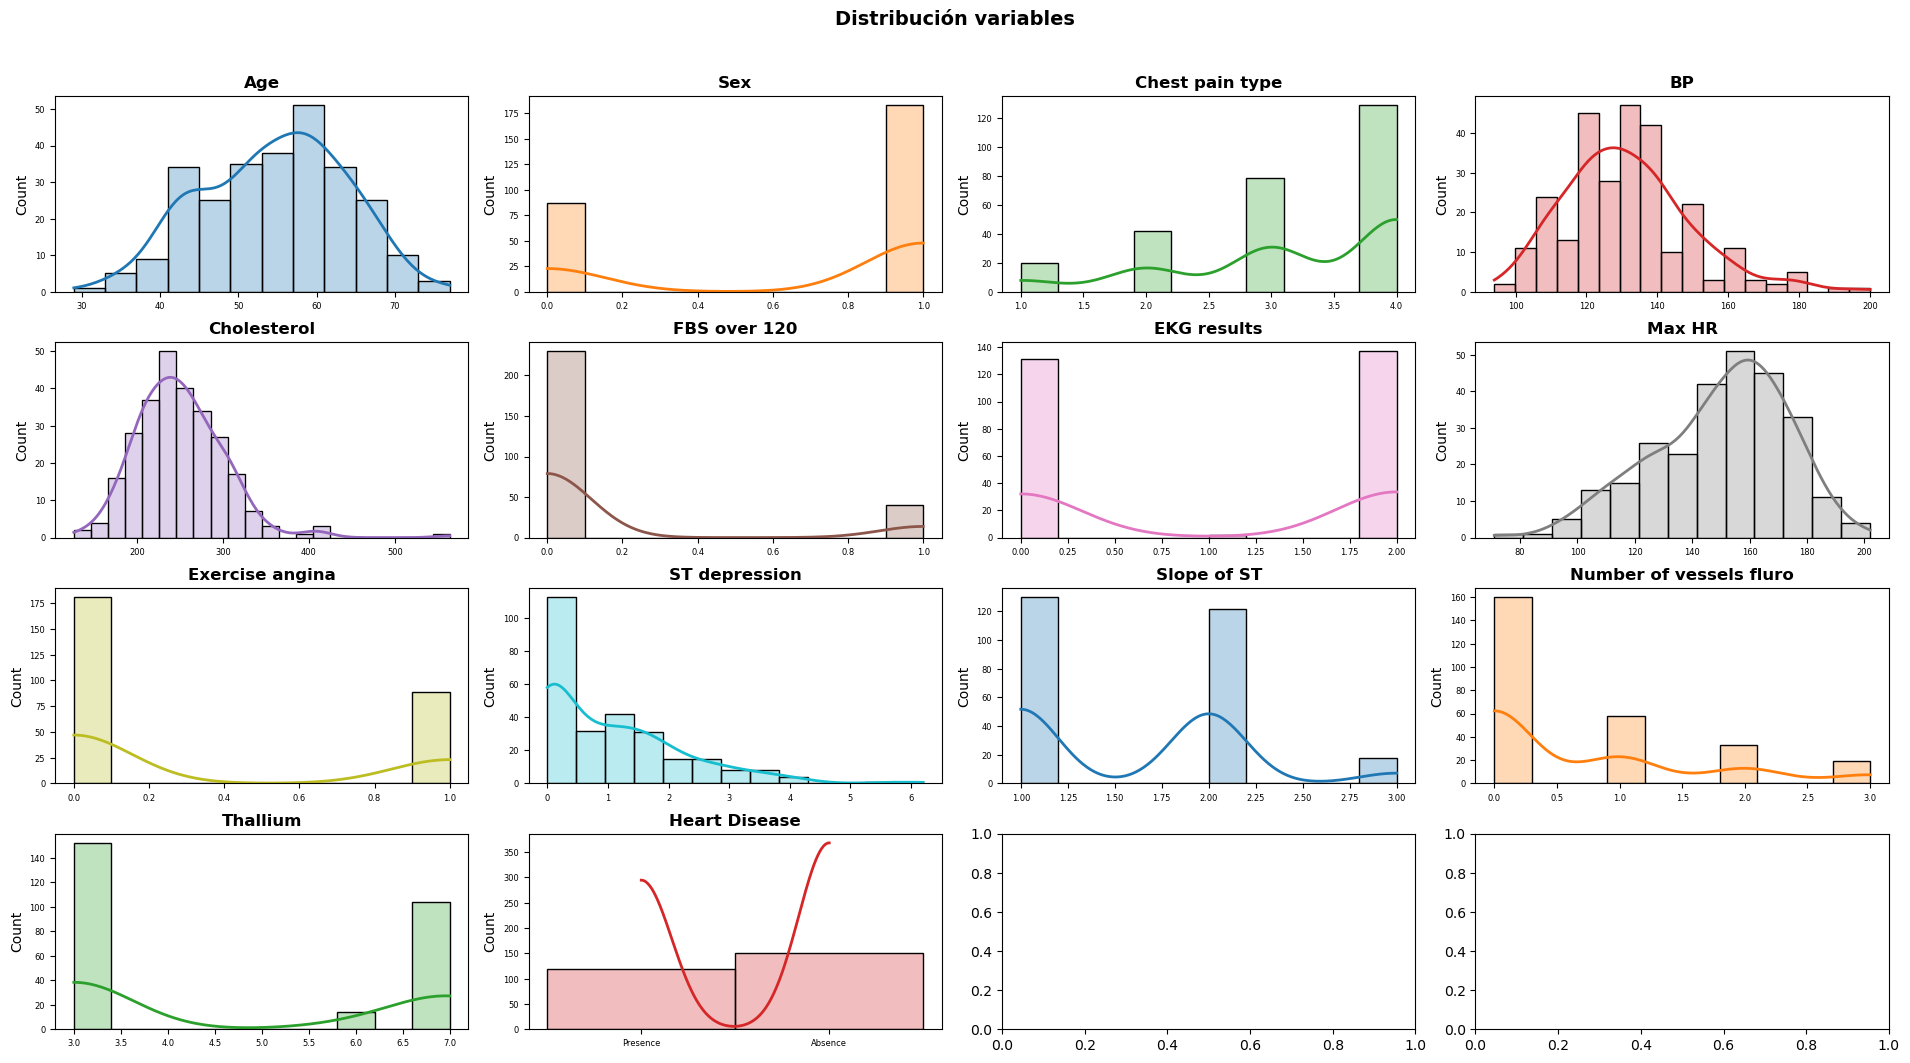

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(19.2, 10.8))
axes = axes.flat
for i, colum in enumerate(lista_var):
    sns.histplot(
        data    = df,
        x       = colum,
        stat    = "count",
        kde     =True, #función de densidad de probabilidad 
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
        
    )
    axes[i].set_title(colum, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables', fontsize = 14, fontweight = "bold");

TARGET

In [13]:
TARGET='Heart Disease'

In [14]:
df[TARGET].describe()

count         270
unique          2
top       Absence
freq          150
Name: Heart Disease, dtype: object

Análisis univaraible

In [15]:
df[TARGET].value_counts()

Absence     150
Presence    120
Name: Heart Disease, dtype: int64

In [16]:
df[TARGET]=np.where(df[TARGET]=='Absence',0,1)

In [17]:
df[[TARGET]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Heart Disease  270 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


ANALISIS DE VARIABLES

In [18]:
lista_var=lista_var.to_list()

In [19]:
lista_var.pop(-1)

'Heart Disease'

Atributo:  Age


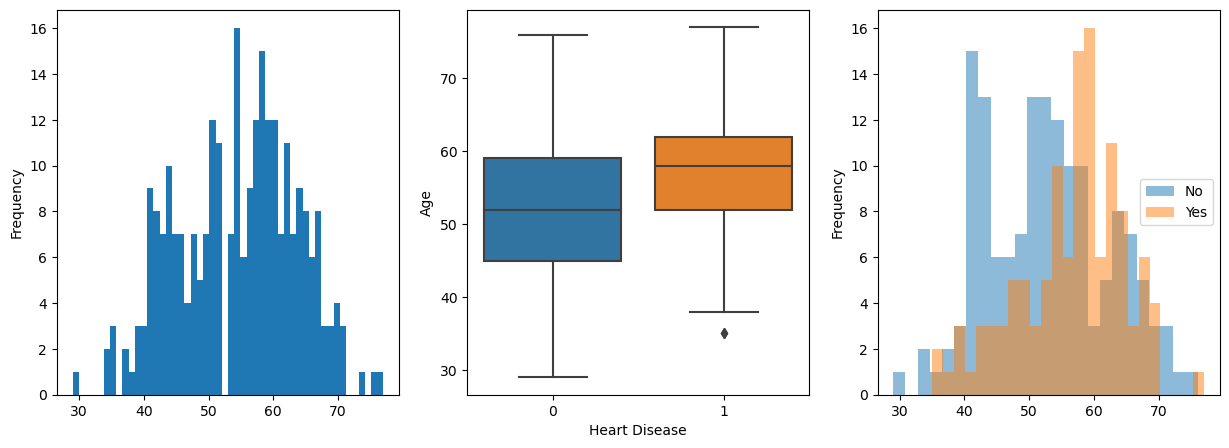

Atributo:  Sex


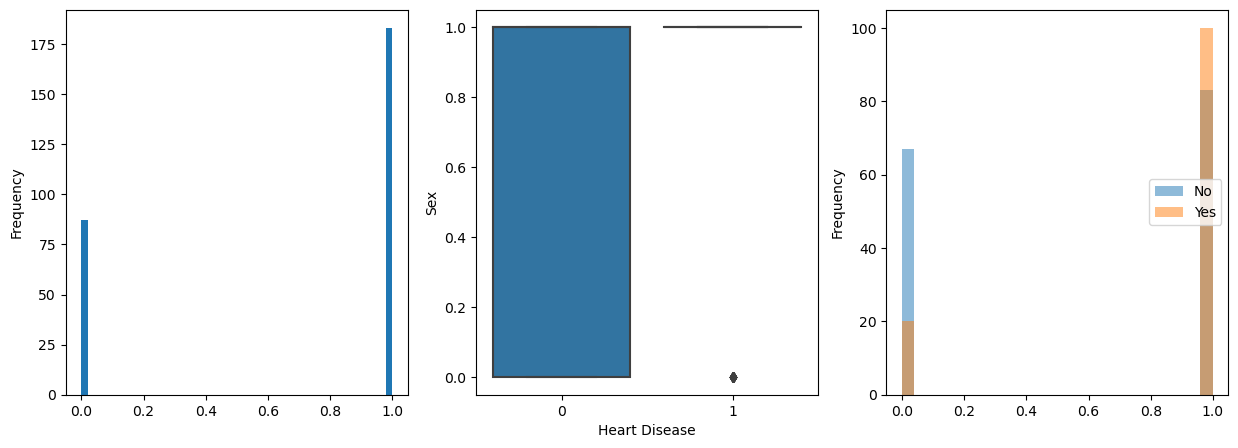

Atributo:  Chest pain type


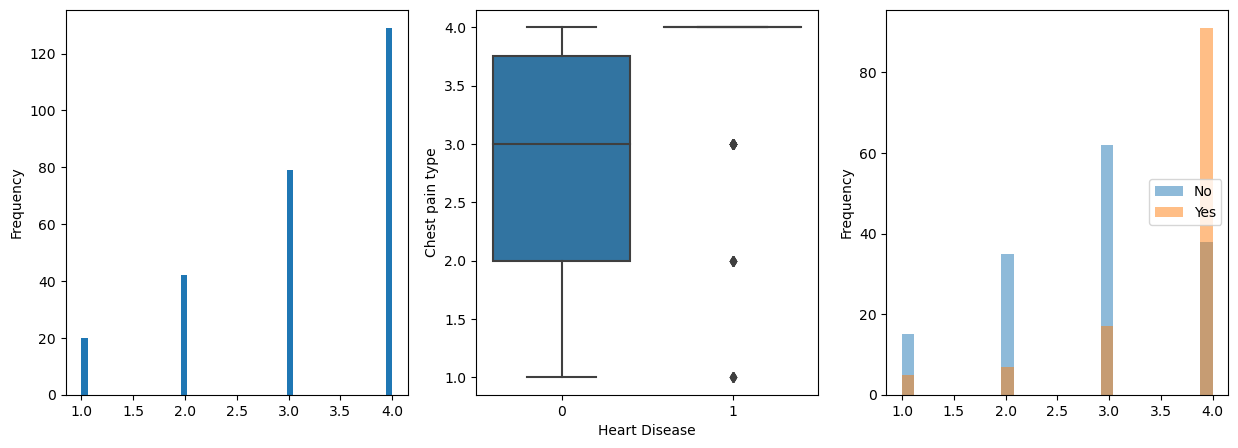

Atributo:  BP


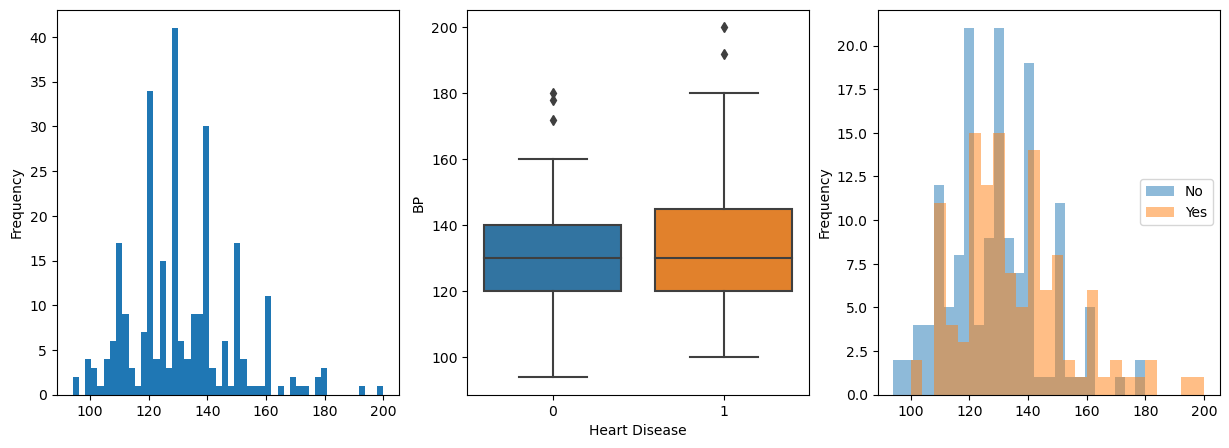

Atributo:  Cholesterol


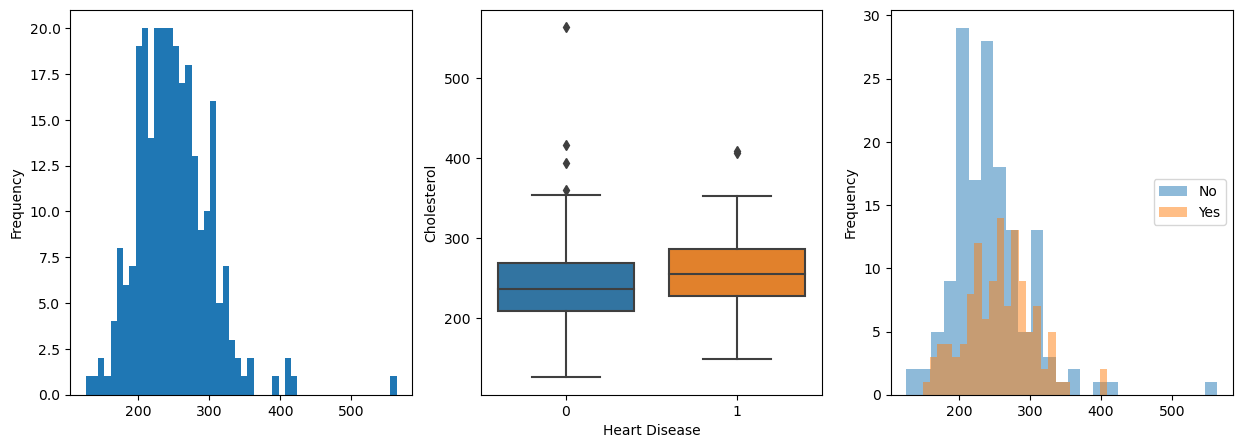

Atributo:  FBS over 120


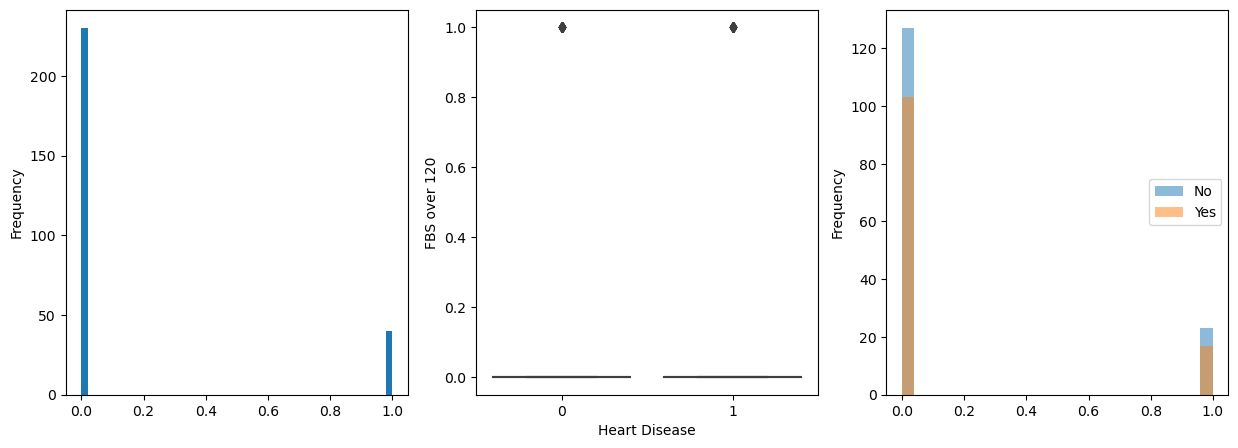

Atributo:  EKG results


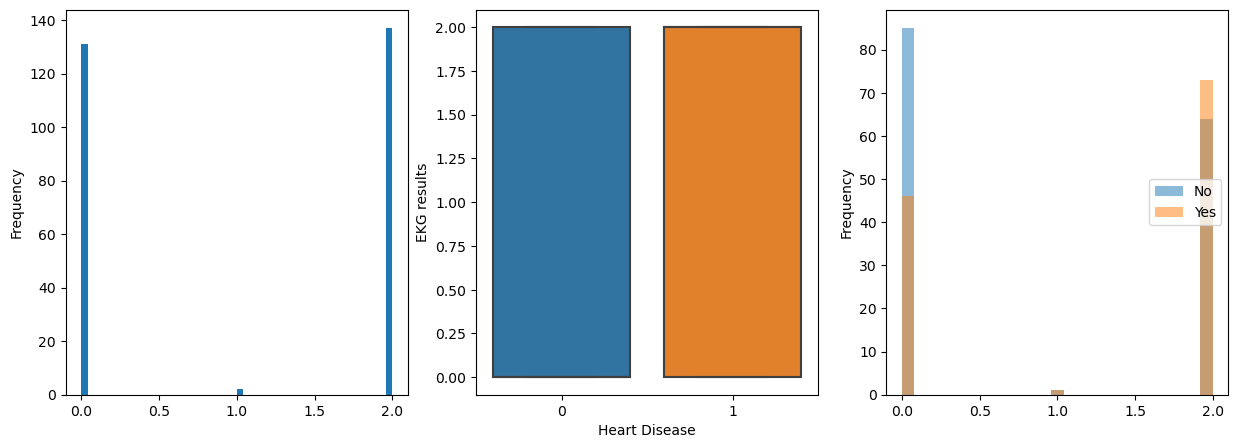

Atributo:  Max HR


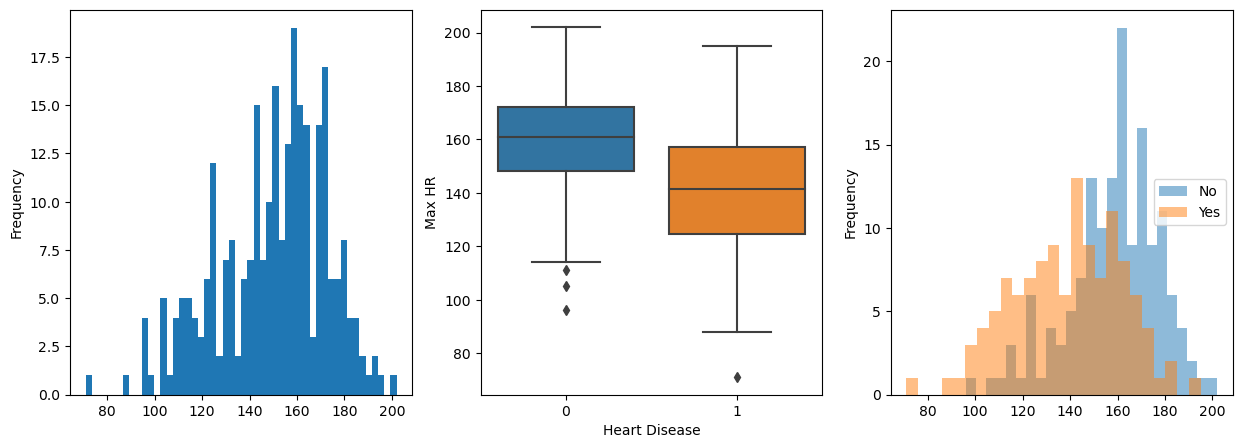

Atributo:  Exercise angina


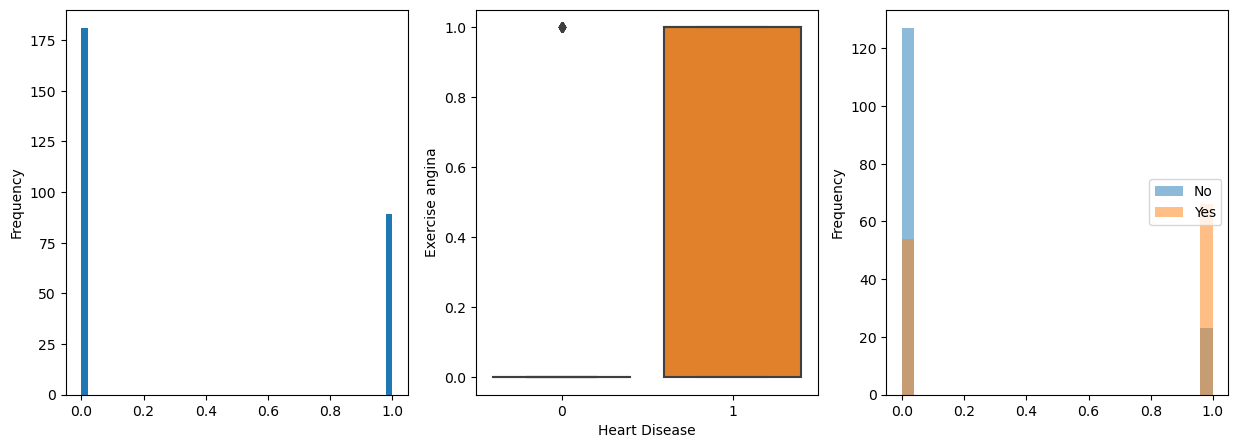

Atributo:  ST depression


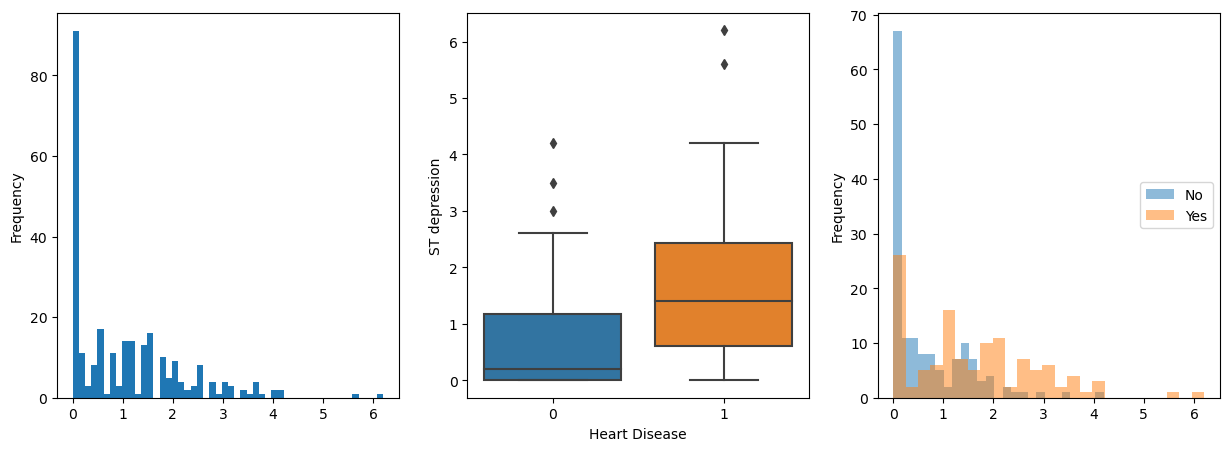

Atributo:  Slope of ST


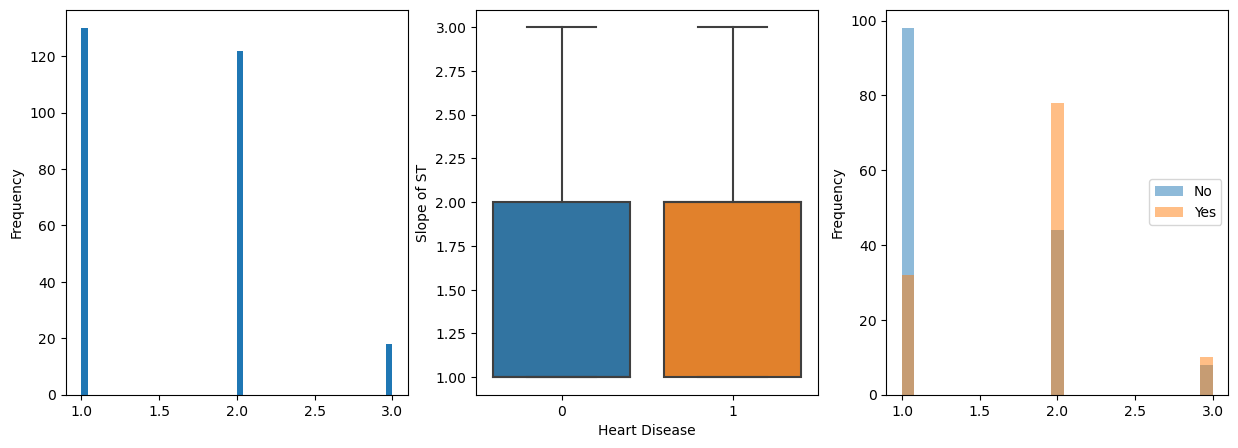

Atributo:  Number of vessels fluro


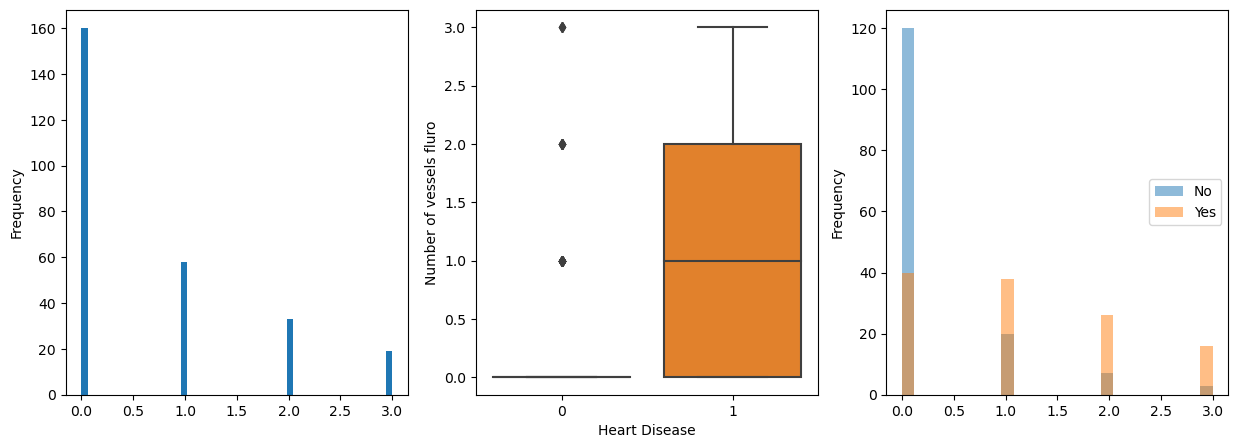

Atributo:  Thallium


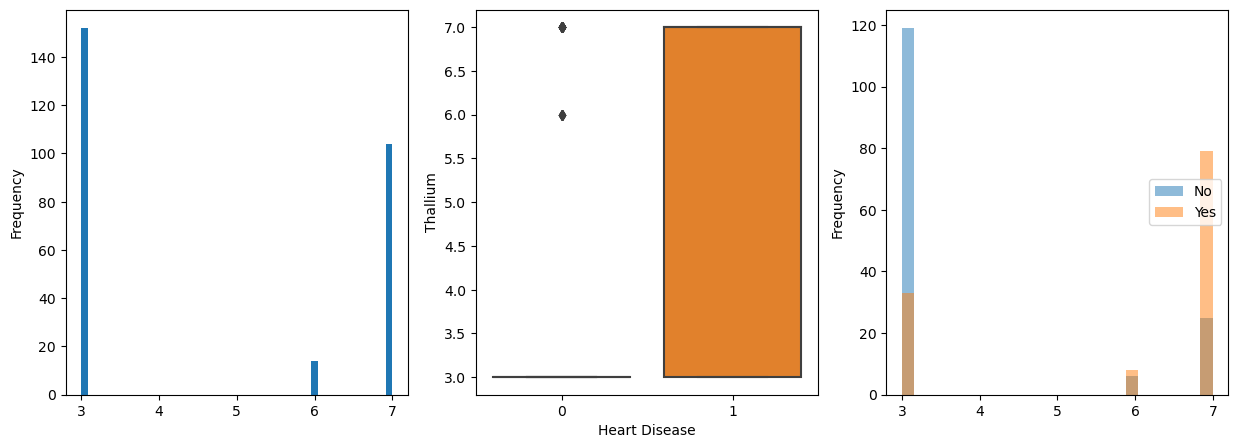

In [20]:
for i in lista_var:
    plot_num(df,i,TARGET)


Correlaciones

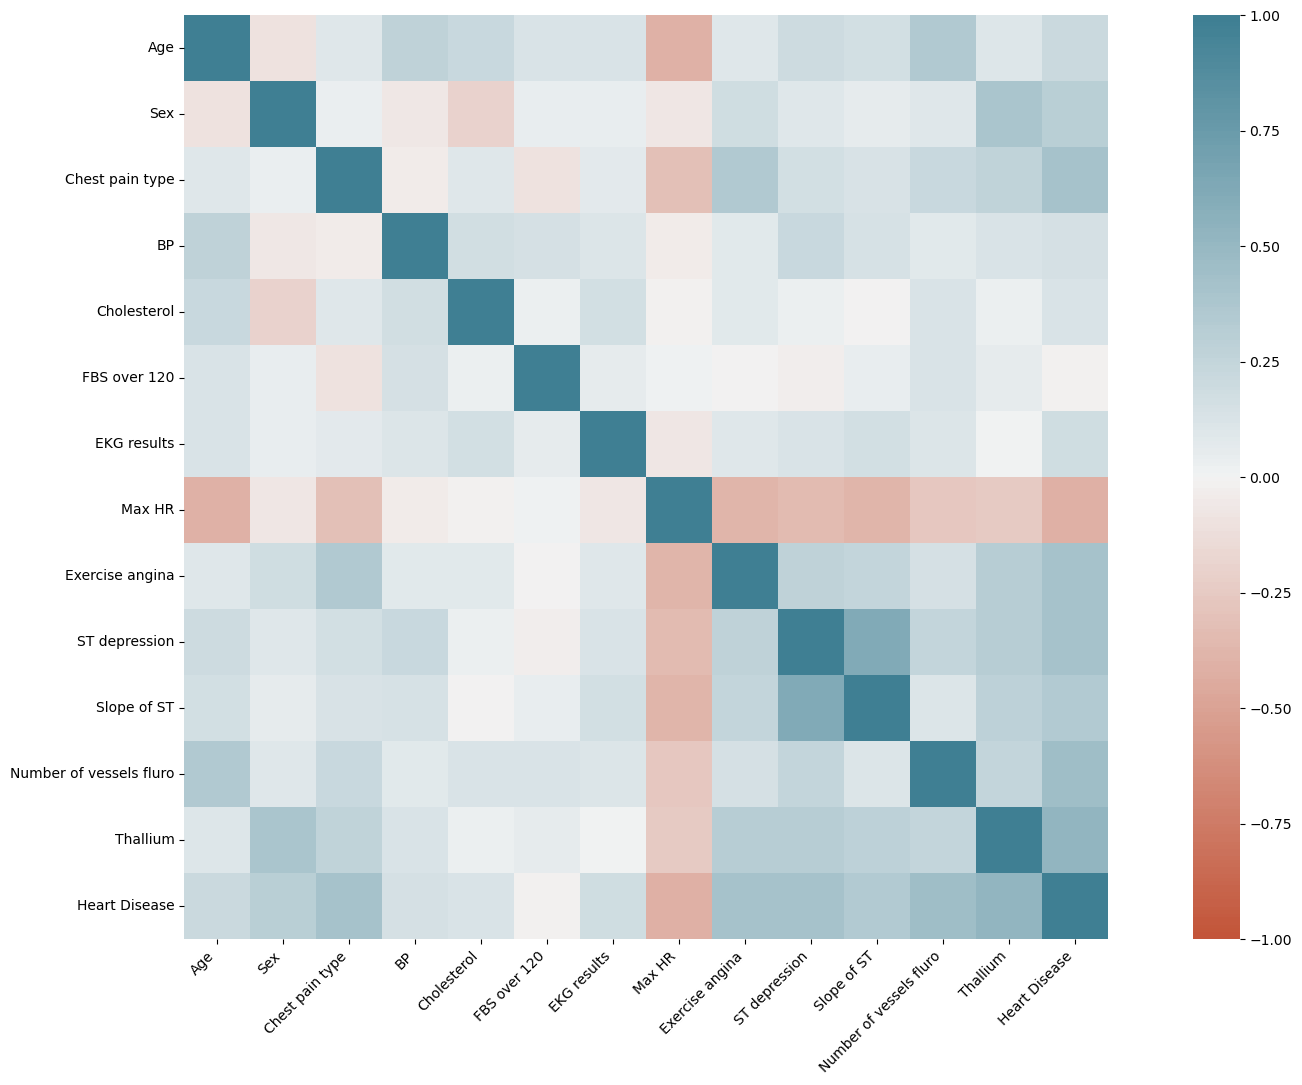

In [21]:
corr = df.corr() 

plt.figure(figsize=(22,12))
ax = sns.heatmap(corr,
                 vmin=-1,
                 vmax=1,
                 center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True)

ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right')

plt.show()

Division train / test

In [22]:
df_X = df.drop(TARGET, axis = 1)
df_y = df[[TARGET]]

In [23]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_X,
                                                                    df_y,
                                                                    test_size=.3,
                                                                    random_state=42)

In [24]:
X_train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Age,189.0,54.751323,9.132393,29.0,48.0,56.0,62.0,74.0
Sex,189.0,0.693122,0.462423,0.0,0.0,1.0,1.0,1.0
Chest pain type,189.0,3.211640,0.966278,1.0,3.0,4.0,4.0,4.0
BP,189.0,131.809524,17.952233,94.0,120.0,130.0,140.0,200.0
Cholesterol,189.0,251.529101,52.554890,141.0,215.0,244.0,282.0,564.0


In [25]:
X_test.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Age,81.0,53.691358,9.067307,35.0,46.0,54.0,59.0,77.0
Sex,81.0,0.641975,0.482407,0.0,0.0,1.0,1.0,1.0
Chest pain type,81.0,3.086420,0.911009,1.0,3.0,3.0,4.0,4.0
BP,81.0,130.259259,17.711421,94.0,120.0,130.0,140.0,192.0
Cholesterol,81.0,245.296296,49.644094,126.0,208.0,249.0,273.0,407.0


In [26]:
y_train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Heart Disease,189.0,0.465608,0.500141,0.0,0.0,0.0,1.0,1.0


In [27]:
y_test.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Heart Disease,81.0,0.395062,0.49191,0.0,0.0,0.0,1.0,1.0


Lanzamiento del modelo

Controlar overfitting

In [28]:
for i in range(1,18):  
  dt_overfit = DecisionTreeClassifier(max_depth = i, random_state = 42, min_samples_split= 20)

  dt_overfit.fit(X_train, y_train)
    
  train_acc = np.round(dt_overfit.score(X_train, y_train),4)
  test_acc = np.round(dt_overfit.score(X_test, y_test),4)

  print(f'Profundidad del arbol: {i}, train acc: {train_acc}, test acc: {test_acc}, overfit : {train_acc - test_acc}')

Profundidad del arbol: 1, train acc: 0.7619, test acc: 0.7654, overfit : -0.0034999999999999476
Profundidad del arbol: 2, train acc: 0.8148, test acc: 0.7037, overfit : 0.11109999999999998
Profundidad del arbol: 3, train acc: 0.836, test acc: 0.7037, overfit : 0.13229999999999997
Profundidad del arbol: 4, train acc: 0.836, test acc: 0.7037, overfit : 0.13229999999999997
Profundidad del arbol: 5, train acc: 0.836, test acc: 0.7037, overfit : 0.13229999999999997
Profundidad del arbol: 6, train acc: 0.836, test acc: 0.7037, overfit : 0.13229999999999997
Profundidad del arbol: 7, train acc: 0.836, test acc: 0.7037, overfit : 0.13229999999999997
Profundidad del arbol: 8, train acc: 0.836, test acc: 0.7037, overfit : 0.13229999999999997
Profundidad del arbol: 9, train acc: 0.836, test acc: 0.7037, overfit : 0.13229999999999997
Profundidad del arbol: 10, train acc: 0.836, test acc: 0.7037, overfit : 0.13229999999999997
Profundidad del arbol: 11, train acc: 0.836, test acc: 0.7037, overfit : 0

train acc se estanca en profundidad 3
test acc se estanca en 1
apropiate fit:
maximo test acc: profundidad 1


In [29]:
rf = RandomForestClassifier(n_estimators = 10, max_depth = 3, random_state = 42)

In [30]:
rf.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(max_depth=3, n_estimators=10, random_state=42)

In [31]:
tree_list = rf.estimators_

In [32]:
rf_tree0 = export_graphviz(tree_list[0], 
                 out_file=None, 
                 max_depth=None, 
                 feature_names=X_test.columns, 
                 class_names=['No_Heart_Disease', 'Heart_Disease'], 
                 label='all', 
                 filled=True, 
                 leaves_parallel=False, 
                 impurity=True, 
                 node_ids=False, 
                 proportion=True, 
                 rotate=True, 
                 rounded=False, 
                 special_characters=False, 
                 precision=3, fontname='helvetica')

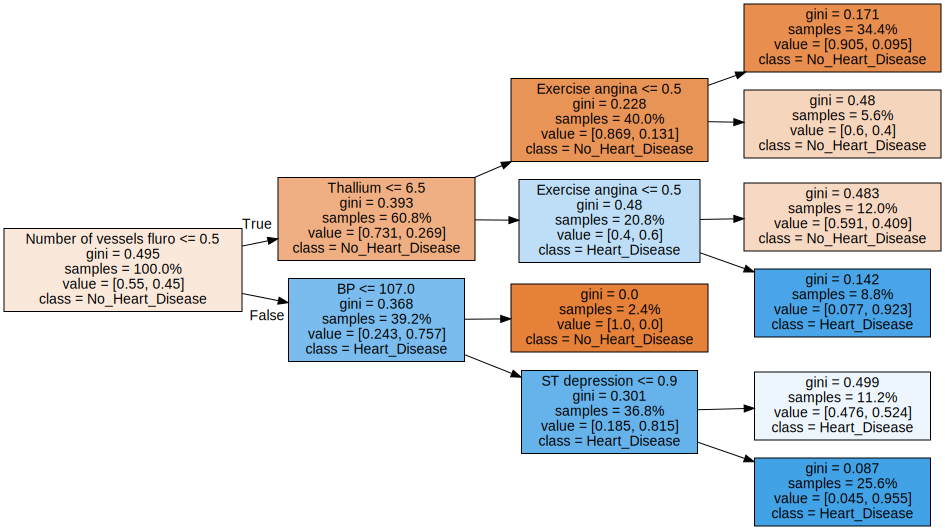

In [33]:
graphviz.Source(rf_tree0)

Evaulación de Modelo

In [34]:
y_test_pred = pd.DataFrame(rf.predict(X_test), 
                            index = y_test.index, 
                            columns = ['Disease_pred'])

In [35]:
results_rf = y_test.join(y_test_pred)

In [36]:
results_rf

,Heart Disease,Disease_pred
30,1,1
116,1,0
79,0,0
127,0,0
196,0,0
...,...,...
55,0,0
97,1,0
200,0,1
38,0,0


In [37]:
results_rf['Success'] = (results_rf['Heart Disease'] == results_rf['Disease_pred']).astype(int)

In [38]:
results_rf

,Heart Disease,Disease_pred,Success
30,1,1,1
116,1,0,0
79,0,0,1
127,0,0,1
196,0,0,1
...,...,...,...
55,0,0,1
97,1,0,0
200,0,1,0
38,0,0,1


In [39]:
results_rf['Success'].mean()

0.8024691358024691

In [40]:
rf.score(X_test,y_test)

0.8024691358024691

Confusion Matrix

In [41]:
confusion_matrix = pd.crosstab(results_rf[TARGET],results_rf['Disease_pred'])

In [42]:
confusion_matrix

Disease_pred,0,1
Heart Disease,,
0,46,3
1,13,19


In [43]:
TP = confusion_matrix.iloc[1,1]
FP = confusion_matrix.iloc[0,1]
TN = confusion_matrix.iloc[0,0]
FN = confusion_matrix.iloc[1,0]

In [44]:
accuracy = (TN + TP)/(TN + TP + FP + FN)
accuracy

0.8024691358024691

In [45]:
print(f'Nuestro accuracy ed de {np.round(accuracy,2)}')
print(f'La media del target de nuestro dataset es {np.round(df[TARGET].mean(),2)}')
print (f'Ganamos un {np.round((accuracy - df[TARGET].mean())*100, 2)}%')

Nuestro accuracy ed de 0.8
La media del target de nuestro dataset es 0.44
Ganamos un 35.8%


F1 score

In [46]:
Precision = (TP)/(TP + FP)
Recall = (TP)/(TP+FN)

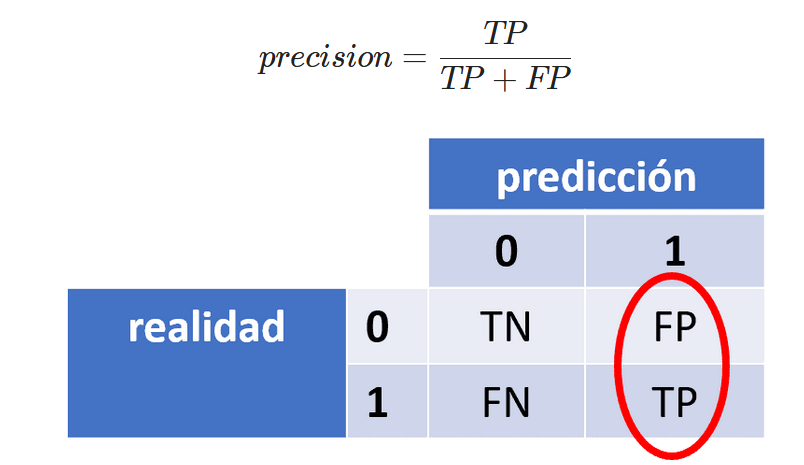


In [47]:
#Calidad del modelo de machine learning en tareas de clasificación.
# De los que se predijeron como TRUE, cuáles realmente lo fueron
#Esto significa que el modelo se equivocará un 23%
#de las veces cuando prediga Disease.
Precision

0.8636363636363636

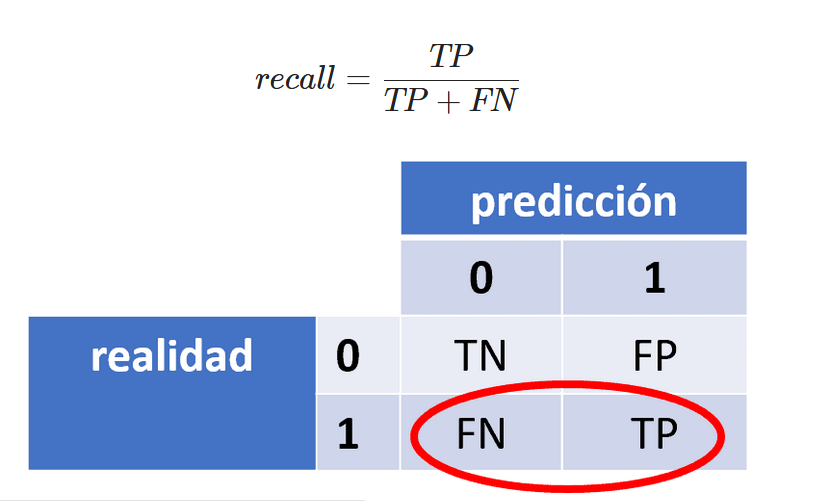

In [48]:
#la cantidad que el modelo de ML es capaz de identificar
# de los que realmente tienen la disease, cuántos logré indentificar. Exhaustividad
#El modelo es capaz de indentificar el 62% de los pacientes con enfermedad.
Recall

0.59375

In [49]:
f1_score = 2 / (1/Precision + 1/Recall)
f1_score

0.7037037037037037

In [50]:
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import f1_score

Combinar las medidas de precisión y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de la precisión y la exhaustividad

In [51]:
metrics.f1_score(y_test,y_test_pred)

0.7037037037037037

ROC CURVE

In [52]:
y_score = pd.DataFrame(rf.predict_proba(X_test)[:,1], index = y_test.index, columns = ['Disease_score'])

In [53]:
results_rf = results_rf.join(y_score)

In [54]:
results_rf

,Heart Disease,Disease_pred,Success,Disease_score
30,1,1,1,0.536725
116,1,0,0,0.457941
79,0,0,1,0.130301
127,0,0,1,0.118801
196,0,0,1,0.461073
...,...,...,...,...
55,0,0,1,0.062229
97,1,0,0,0.310149
200,0,1,0,0.522870
38,0,0,1,0.263144


In [55]:
metrics.roc_auc_score(results_rf[TARGET],results_rf['Disease_score'])

0.8667091836734694

In [56]:
fpr, tpr, th = metrics.roc_curve(results_rf[TARGET],results_rf['Disease_score'])

Text(0.5, 1.0, 'ROC Curve')

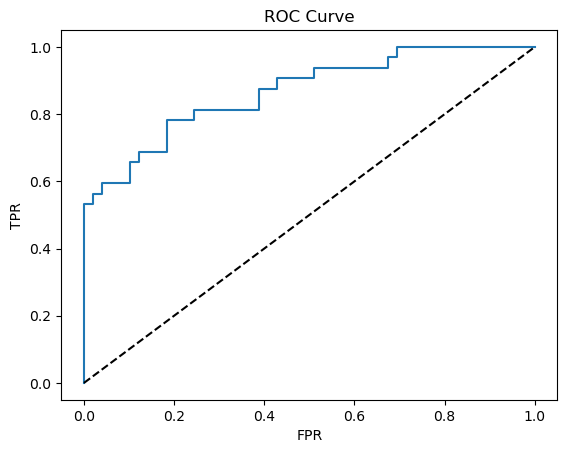

In [57]:
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1], color = 'black', linestyle = '--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

Las predicciones se basan en varios decision trees, no podemos ver directamente la prediccion. Pero podemos ver el feature importance:

In [58]:
top_features = pd.Series(rf.feature_importances_, index = X_train.columns).sort_values(ascending = False)

In [59]:
top_features.head()

Number of vessels fluro    0.178235
Thallium                   0.149257
Max HR                     0.122508
ST depression              0.120960
Exercise angina            0.117072
dtype: float64